In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from skimage import color
from skimage import io
from random import randint
from sklearn import preprocessing
from sklearn.decomposition import PCA
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

Download SVHN dataset 

In [ ]:
# download train and test data
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2021-09-04 12:26:41--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  17.9MB/s    in 10s     

2021-09-04 12:26:52 (16.7 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-09-04 12:26:52--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  16.9MB/s    in 4.2s    

2021-09-04 12:26:57 (14.5 MB/s) - ‘test_32x32.mat’ saved [64275384/64

Preprocessing steps from https://github.com/aditya9211/SVHN-CNN/blob/master/data_preprocess.ipynb

Dataset is a numpy ndarray of shape (size, width, height, channels)

In [ ]:
# helper function for loading a MAT-File
def load_data(path):
    data = loadmat(path)
    return data['X'], data['y']

X_train, y_train = load_data('train_32x32.mat')
X_test, y_test = load_data('test_32x32.mat')

# transposing the the train and test data by converting it from  (width, height, channels, size) -> (size, width, height, channels)
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]

print("Training Set", X_train.shape)
print("Test Set", X_test.shape)
print('')

# calculate the total number of images
num_images = X_train.shape[0] + X_test.shape[0]

print("Total Number of Images", num_images)

Training Set (73257, 32, 32, 3)
Test Set (26032, 32, 32, 3)

Total Number of Images 99289


In [ ]:
# plotting function for fig in n rows X m columns
def plot_images(img, labels, nrows, ncols):
    """ Plot nrows x ncols images
    """
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])

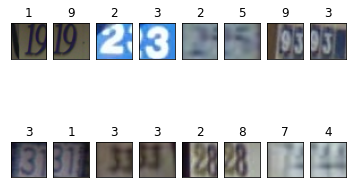

In [ ]:
# plot some of the training images
plot_images(X_train, y_train, 2, 8)

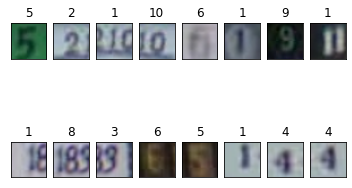

In [ ]:
# plot some test set images
plot_images(X_test, y_test, 2, 8)

In [ ]:
# to check unique labels
classes = np.unique(y_train)
num_classes = len(classes)
print(classes)

[ 1  2  3  4  5  6  7  8  9 10]


Question : Compute the Data Covariance matrix for each class (e.g., digit, character) separately and then 
entire dataset.

In [ ]:
# flattening 3 channel, 2-D images into image vectors
X_vecs = X_train.reshape(X_train.shape[0], -1)

# extract examples by class
def get_examples(X, y, cl):
  return np.take(X, list(np.where(y==cl)[0]), axis=0)

# examples of each class
x_by_class = []
for i in range(1, num_classes+1):
  x_by_class.append(get_examples(X_vecs, y_train, i))

# covariance matrix for each class
cov_by_class = []
for i in range(num_classes):
  cov_by_class.append(np.cov(x_by_class[i].T))

# covariance matrix for entire train set
cov_x = np.cov(X_vecs.T)

Question : Which class has the minimum and maximum total variance (spread)? Let’s call them class A 
and B respectively. Provide some example images from class A and B.  

Class 5 has minimum total variance
Class 1 has maximum total variance
Images from min variance class :


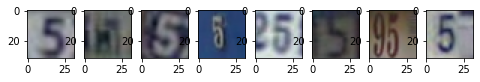

Images from max variance class :


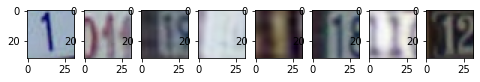

In [ ]:
# total variance is given by the trace of the covariance matrix
tot_var = []
for cov in cov_by_class:
  tot_var.append(np.trace(cov))

tot_var = np.array(tot_var)
min_class = np.argmin(tot_var) + 1  # since index starts from 0
max_class = np.argmax(tot_var) + 1
print('Class {} has minimum total variance'.format(min_class))  
print('Class {} has maximum total variance'.format(max_class))

# min class images
min_x = get_examples(X_train, y_train, min_class)
# max class images
max_x = get_examples(X_train, y_train, max_class)

# plotting random images from the two classes
columns = 8
rows = 2

# plotting images from min variance class
print('Images from min variance class :')
fig = plt.figure(figsize=(8, 8))
for i in range(1, columns +1):
    img = min_x[np.random.randint(0, min_x.shape[0])]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# plotting images from max variance class
print('Images from max variance class :')
fig = plt.figure(figsize=(8, 8))
for i in range(1, columns +1):
    img = max_x[np.random.randint(0, max_x.shape[0])]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

Question :  Perform normalization on the data from each class. Which method is more appropriate here? 

The attribute values are in similar scales. Also we want to apply PCA on the data which captures the directions of maximal variance in the data. Thus we would want our all our features to be standardized, with approximately zero mean and unit standard deviation. We use standard score normalization as a result.

In [ ]:
# standardizing with sklearn
scaler = preprocessing.StandardScaler()
scaled_classes = [scaler.fit(x).transform(x) for x in x_by_class]

Question : Use PCA and related techniques to visualize  the  data  in  class  A  and  B 
individually and together. Are the two classes distinguishable? 

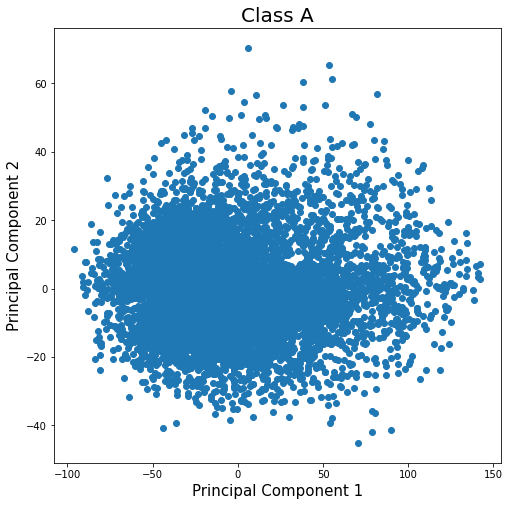

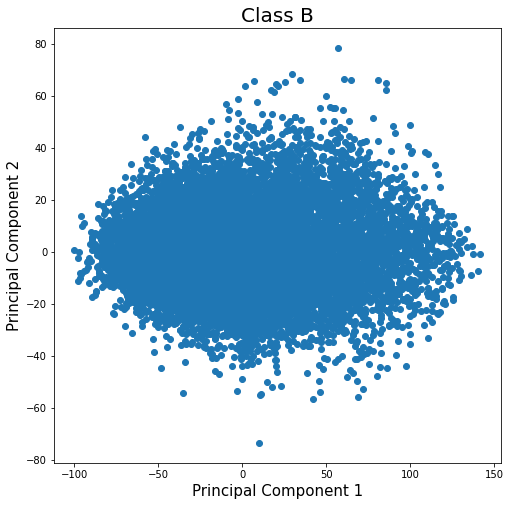

In [ ]:
# class A refers to the class with minimum total variance
A = scaled_classes[min_class - 1]

# class B refers to the class with maximum total variance
B = scaled_classes[max_class - 1]

# applying PCA with 2 principal components
pca = PCA(n_components=2)
pcompsA = pca.fit_transform(A)
pcompsB = pca.fit_transform(B)

# plotting separately
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Class A', fontsize = 20)
ax.scatter(pcompsA[:, 0], pcompsA[:, 1])

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Class B', fontsize = 20)
ax.scatter(pcompsB[:, 0], pcompsB[:, 1])

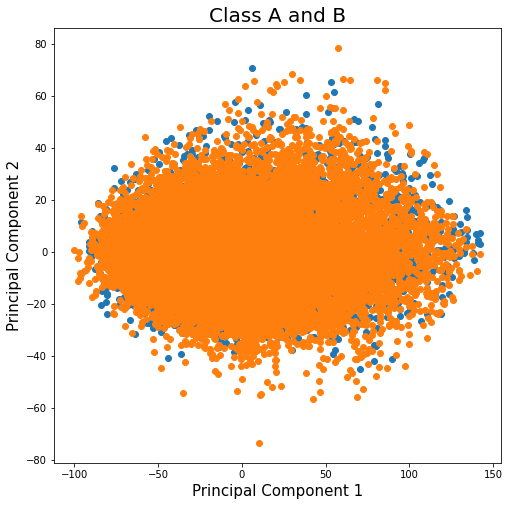

In [ ]:
# plotting together
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Class A and B', fontsize = 20)
ax.scatter(pcompsA[:, 0], pcompsA[:, 1])
ax.scatter(pcompsB[:, 0], pcompsB[:, 1])

The two classes are not distinguishable in a 2 component PCA plot

Question : Take  10  random  test  images  from  the  test  set  of  classes  A  and  B  each.  Assuming  that  the 
distribution of each class is a multi-variate normal (with parameters same as that of the sample covariance 
matrix for that class), compute the probability of each image belonging to class A and B. How accurate is 
your classifier?  

Let $y$ be a Bernoulli random variable with mean $\phi$ that captures the probability of a point belonging to class A or B. If $x$ denotes the data points then according to the question we assume $x|y=0 \sim N(\mu_{0}, \Sigma_{0})$ and $x|y=1 \sim N(\mu_{1}, \Sigma_{1})$, where $y=0$ and $y=1$ denote the two classes A and B. The goal is to find $\underset{y}{\operatorname{argmax}p(y|x)} = \underset{y}{\operatorname{argmax}}\frac{p(x|y)p(y)}{p(x)}=\underset{y}{\operatorname{argmax}}p(x|y)p(y)$

$p(x|y)$ is multivariate normal and can be calculated once we know $\mu$ and $\Sigma$. Since $y$ is Bernoulli, $p(y) = \phi^y(1-\phi)^{1-y}$ and $\phi$ is given by $\phi = \frac{1}{m}\sum_{i=1}^{i=m}1\{y^{i}=1\}$, where m is the number of examples and 1{ } denotes the indicator function. 

In [ ]:
"""n = 3072
sig = np.cov(A.T)
mu = np.mean(A, axis=0)
x = X_vecs[5]
# calculating the probability (p(x|y)) causes overflow due to the high dimensionality
np.exp(-0.5*np.matmul((x-mu).T, np.matmul(np.linalg.inv(sig), x-mu)))/(np.power(2*np.pi, n/2) * np.sqrt(np.linalg.det(sig)))  # OVERFLOW"""

Question : Repeat the above exercise with a 5-nearest neighbor approach in lower dimensions using your 
favorite dimensionality reduction technique.   

In [ ]:
# we use PCA to reduce dimensionality
n = X_vecs.shape[1] # original dimension of data
k = 5 # number of neighbors

pca = PCA(n_components=n//2)  # using n/2 dimensions
X_nby2 = pca.fit_transform(X_vecs) # transforming the train set
X_nby2_test = pca.fit_transform(X_test.reshape(X_test.shape[0], -1))  # transforming the test set

neigh = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
X1 = get_examples(X_nby2, y_train, min_class) # getting examples from class A
X2 = get_examples(X_nby2, y_train, max_class) # getting examples from class B
X = np.vstack((X1, X2)) # stacking the examples together
Y = (np.ones(X1.shape[0])*min_class).reshape(-1, 1)
Y = np.vstack((Y, (np.ones(X2.shape[0])).reshape(-1, 1))).flatten() # stacking the corrsponding y's together

neigh.fit(X, Y)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
# getting test examples corresponding to classes A and B
test_examples_A = get_examples(X_nby2_test, y_test, min_class)
test_examples_B = get_examples(X_nby2_test, y_test, max_class)

score = 0
for i in range(10): # selecting 10 random examples from class A and B
  cls =  randint(0,1) # randomly choose between class A and B
  if cls == 0:  # class A
    c = min_class
    idx = randint(0, test_examples_A.shape[0])
    example = test_examples_A[idx]  # randomly select an example from class A
  else :  # class B
    c = max_class
    idx = randint(0, test_examples_B.shape[0])
    example = test_examples_B[idx]  # randomly select an example from class B

  if neigh.predict([example])[0] == c: score += 1 # predict class and add to score if correct
  
print('accuracy of classifier :', score / 10)

accuracy of classifier : 0.6
